In [1]:
import json
import random
import time
import math
import sys
import yaml
import logging
from dataclasses import dataclass, field
from pathlib import Path
from typing import Dict

import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.agent import AgentSet

try:
    import networkx as nx
    HAS_NX = True
except ImportError:
    HAS_NX = False

# ---------------------------------------------------------------------------
# config.yaml integration (matching sim_nouhaila.ipynb)
# ---------------------------------------------------------------------------
sys.path.insert(0, str(Path.cwd()))

try:
    from utils.config import load_config, get_config
    from utils.logger import setup_logging
    config = load_config("config.yaml")
    logger = setup_logging(
        log_level=config.simulation.get("log_level", "INFO"),
        log_file=config.logging_config.get("log_file"),
    )
    USE_CONFIG_FILE = True
except Exception:
    logging.basicConfig(level=logging.INFO, format="%(message)s")
    logger = logging.getLogger("AgroAI")
    USE_CONFIG_FILE = False
    logger.info("config.yaml / utils not found — using embedded defaults")

print(f"Config source: {'config.yaml' if USE_CONFIG_FILE else 'embedded defaults'}")

2026-02-15 00:41:34,369 - agroai_sim - INFO - Logging to logs\simulation.log


Config source: config.yaml


In [3]:
# =============================================================================
# SIM_CONFIG — populated from config.yaml when available
# =============================================================================
@dataclass
class SIM_CONFIG:
    n_agents: int = 100
    n_seasons: int = 30
    random_seed: int = 42
    noise_std: float = 0.10
    suitability_noise_std: float = 0.08
    use_neighbor_graph: bool = True
    network_topology: str = "small_world"
    network_k: int = 4
    knowledge_filter_mode: str = "filter"
    shared_strategy: str = "both"
    use_profit: bool = True
    # Suitability weights
    zone_weight: float = 0.30
    soil_weight: float = 0.25
    climate_weight: float = 0.25
    moisture_weight: float = 0.10
    # Learning weights
    shared_weight: float = 0.60
    neighbor_weight: float = 0.20
    experience_weight: float = 0.25
    min_neighbor_obs: int = 3
    # Yield
    variability_min: float = 0.85
    variability_max: float = 1.15
    # Finance (from config.yaml → finance section)
    price_volatility: float = 0.15
    market_shock_probability: float = 0.05
    shared_price_premium: float = 0.20
    shared_cost_efficiency: float = 0.70
    shared_post_harvest_loss: float = 0.05
    indiv_cost_efficiency: float = 0.90
    indiv_post_harvest_loss: float = 0.15
    input_cost_inflation: float = 0.02


def build_cfg():
    """Return a SIM_CONFIG populated from config.yaml if available."""
    if USE_CONFIG_FILE:
        _c = config
        return SIM_CONFIG(
            n_agents       = _c.simulation.get("n_agents", 100),
            n_seasons      = _c.simulation.get("n_timesteps", 30),
            random_seed    = _c.simulation.get("random_seed", 42),
            zone_weight    = _c.suitability.get("zone_weight", 0.30),
            soil_weight    = _c.suitability.get("soil_weight", 0.25),
            climate_weight = _c.suitability.get("climate_weight", 0.25),
            moisture_weight= _c.suitability.get("moisture_weight", 0.10),
            shared_weight  = _c.learning.get("shared_weight", 0.60),
            neighbor_weight= _c.learning.get("individual_weight", 0.20),
            experience_weight= _c.learning.get("individual_weight", 0.25),
            variability_min= _c.yield_params.get("variability_min", 0.85),
            variability_max= _c.yield_params.get("variability_max", 1.15),
            price_volatility       = _c.finance.get("price_volatility", 0.15),
            market_shock_probability= _c.finance.get("market_shock_probability", 0.05),
            shared_price_premium   = _c.finance.get("shared_price_premium", 0.20),
            shared_cost_efficiency = _c.finance.get("shared_cost_efficiency", 0.70),
            shared_post_harvest_loss= _c.finance.get("shared_post_harvest_loss", 0.05),
            indiv_cost_efficiency  = _c.finance.get("individual_cost_efficiency", 0.90),
            indiv_post_harvest_loss= _c.finance.get("individual_post_harvest_loss", 0.15),
            input_cost_inflation   = _c.finance.get("input_cost_inflation", 0.02),
            drought_probability    = _c.yield_params.get("drought_years_probability", 0.15),
            flood_probability      = _c.yield_params.get("flood_probability", 0.08),
            pest_probability       = _c.yield_params.get("pest_pressure_baseline", 0.40),
        )
        )
    return SIM_CONFIG()

# Display active config
_cfg_preview = build_cfg()
print(f"Config: n_agents={_cfg_preview.n_agents}, n_seasons={_cfg_preview.n_seasons}, "
      f"seed={_cfg_preview.random_seed}")

# =============================================================================
# Load ALL real data sources (crops.json, zones.json, climate, soil moisture)
# =============================================================================
DATA_DIR = Path("./data")

def _load_json(path):
    with open(path, encoding="utf-8") as f:
        return json.load(f)

zones_data     = _load_json(DATA_DIR / "zones.json")
crops_data     = _load_json(DATA_DIR / "crops.json")
climate_data   = _load_json(DATA_DIR / "climate_profiles.json")
soil_moisture  = _load_json(DATA_DIR / "soil_moisture_profiles.json")

ZONE_IDS = list(zones_data["zones"].keys())
CROP_IDS = list(crops_data["crops"].keys())
logger.info(f"Loaded {len(ZONE_IDS)} zones: {', '.join(ZONE_IDS)}")
logger.info(f"Loaded {len(ZONE_IDS)} zones: {', '.join(ZONE_IDS)}")
logger.info(f"Loaded {len(CROP_IDS)} crops from FAOSTAT/EcoCrop database")
logger.info(f"Cost model: SMAG={crops_data['cost_model']['smag_mad_per_day']} MAD/day")
print(f"✓ {len(ZONE_IDS)} zones, {len(CROP_IDS)} crops loaded")

# =============================================================================
# Zone class with environmental state (drought, flood, pest)
# =============================================================================
class Zone:
# Zone class
    def __init__(self, zone_id, data, climate_profile, soil_moisture_data):
        self.id = zone_id
    """Agro-ecological zone with real data."""
        self.soil_types = data["soil_types"]
        self.dominant_soil = data["dominant_soil"]
        self.viable_crops = data["viable_crops"]
        self.agriculture_type = data["agriculture_type"]
        self.climate_profile = climate_profile
        self.raw_zone_data = data
        self.water_price = data.get("water_price", 0.4)

        sm = soil_moisture_data["zones"].get(zone_id, {})
        self.mean_sm = sm.get("mean", 0.15)
        self.std_sm = sm.get("std", 0.05)

        # Cooperative knowledge pools
        self.shared_crop_yield = {}
        self.shared_crop_profit = {}

        # Environmental state (updated each season by FarmModel)
        self.is_drought_year = False
        self.is_flood_year = False
        self.timestep = 0

# =============================================================================
# Real-Data Cost Model (SMAG + ORMVA + OCP)
# Uses crops.json cost_model instead of hardcoded cost_multiplier
# =============================================================================
def get_cost_per_ha(crop_info, zone, cfg, timestep=0, strategy_type="INDIVIDUAL"):
    """Itemized cost per hectare using REAL data from crops.json cost_model.

    Sources:
      - Labor: labor_days_per_ha × SMAG wage (84.37 MAD/day)
      - Water: water_need_mm × 10 m³/ha × zone-specific ORMVA tariff
      - Fertilizer: OCP NPK prices by crop category
      - Seeds: by crop category
      - Mechanization: by crop category
    """
    cost_model = crops_data.get("cost_model", {})
    cost_cat = crop_info.get("cost_category", "cereal")

    # Labor: labor_days × SMAG rate
    labor_days = crop_info.get("labor_days_per_ha", 20)
    smag = cost_model.get("smag_mad_per_day", 84.37)
    labor_cost = labor_days * smag
    smag = cost_model.get("smag_mad_per_day", 84.37)
    # Water: water_need_mm × 10 m³/ha × zone water_price (ORMVA tariff)
    water_needs = cost_model.get("water_need_mm", {})
    water_pref = crop_info.get("water_need", "medium")
    water_mm = water_needs.get(water_pref, 500)
    water_m3_per_ha = water_mm * 10
    water_cost = water_m3_per_ha * zone.water_price

    # Fertilizer (OCP), seeds, mechanization — by crop category
    fertilizer_cost = cost_model.get("fertilizer_npk_mad_per_ha", {}).get(cost_cat, 2000)
    seeds_cost = cost_model.get("seeds_mad_per_ha", {}).get(cost_cat, 800)
    mech_cost = cost_model.get("mechanization_mad_per_ha", {}).get(cost_cat, 1000)
    seeds_cost = cost_model.get("seeds_mad_per_ha", {}).get(cost_cat, 800)
    total = labor_cost + water_cost + fertilizer_cost + seeds_cost + mech_cost

    # Strategy-specific cost efficiency (cooperative bulk purchasing)
    if strategy_type == "SHARED":
        total *= cfg.shared_cost_efficiency
    else:
        total *= cfg.indiv_cost_efficiency

    # Inflation over time
    total *= (1.0 + cfg.input_cost_inflation) ** timestep
    return total

# =============================================================================
# Real crop price from FAOSTAT (replaces hardcoded category prices)
# =============================================================================
def get_crop_price(crop_id, zone, strategy_type, cfg):
    """FAOSTAT price per ton with volatility, market shocks, and cooperative premium.

    Source: crops.json → faostat_price_mad_per_ton (FAOSTAT Morocco)
    """
    crop_info = crops_data["crops"].get(crop_id, {})
    base_price = crop_info.get("faostat_price_mad_per_ton", 3000)
    crop_info = crops_data["crops"].get(crop_id, {})
    # Random price volatility
    price_var = 1.0 + random.uniform(-cfg.price_volatility, cfg.price_volatility)

    # Rare market shock
    if random.random() < cfg.market_shock_probability:
        price_var *= random.choice([0.6, 0.7, 1.4, 1.5])

    # Zone-level environmental price shock
    price_var *= zone.price_shock_factor

    effective = base_price * price_var
    effective = base_price * price_var
    effective = base_price * price_var

    # SHARED cooperative premium
    if strategy_type == "SHARED":
        effective *= (1.0 + cfg.shared_price_premium)

    return effective

# =============================================================================
# Yield with environmental stressors (drought, flood, pest)
# =============================================================================
def calculate_yield(crop_id, zone, cfg):
# Yield calculation
    crop = crops_data["crops"][crop_id]
    base_yield = crop.get("base_yield_t_ha", 1.0)
    """Yield = base × suitability × variability."""
    # Zone viability
    viable = zone.viable_crops
    zone_viability = 1.0 if crop_id in viable else 0.3
    ideal_soils = crop.get("ideal_soils", [])
    soil_match = 1.0 if zone.dominant_soil in ideal_soils else 0.5

    # Random variability
    variability = cfg.variability_min + (cfg.variability_max - cfg.variability_min) * random.random()
    stress = 1.0
    # Environmental stress
    stress = 1.0
    if zone.is_drought_year:
    return base_yield * zone_viability * soil_match * variability

# =============================================================================
# Full season outcome (yield + FAOSTAT revenue + real costs + profit)
# =============================================================================
def calculate_season_outcome(crop_id, zone, cfg, land_size, strategy_type):
    """Complete revenue-cost-profit using REAL data sources."""
    crop_info = crops_data["crops"][crop_id]

    y = calculate_yield(crop_id, zone, cfg)
    cost_per_ha = get_cost_per_ha(crop_info, zone, cfg, zone.timestep, strategy_type)
    effective_price = get_crop_price(crop_id, zone, strategy_type, cfg)

    # Post-harvest loss
    if strategy_type == "SHARED":
        phl = cfg.shared_post_harvest_loss
    else:
        phl = cfg.indiv_post_harvest_loss

    sellable = y * (1.0 - phl)
    revenue = sellable * effective_price * land_size
    total_cost = cost_per_ha * land_size
    profit = revenue - total_cost

    # Water use from cost_model
    water_needs = crops_data.get("cost_model", {}).get("water_need_mm", {})
    water_mm = water_needs.get(crop_info.get("water_need", "medium"), 500)

    return {
        "yield": y, "cost_per_ha": cost_per_ha, "water_mm": water_mm,
        "effective_price": effective_price, "revenue": revenue,
        "total_cost": total_cost, "profit": profit,
    }

# =============================================================================
# Weather generator from real climate variability data
# =============================================================================
def generate_weather(zone_id, rng):
    """Generate weather type using real climate_profiles.json variability data."""
    zone_climate = climate_data.get("zones", {}).get(zone_id, {})
    variability = zone_climate.get("climate_profile", {}).get("variability", {})
    precip_var = variability.get("precipitation", {})
    drought_freq = precip_var.get("drought_frequency", 0.2)
    wet_freq = precip_var.get("wet_frequency", 0.15)
    r = rng.random()
    if r < drought_freq:
        return "drought"
    if r < drought_freq + wet_freq:
        return "wet"
    return "normal"

# =============================================================================
# Network graph builder
# =============================================================================
def build_graph(farmers, topology="small_world", k=4, seed=None):
    if not HAS_NX:
        print("WARNING: networkx not installed — skipping neighbor graph")
        return None
    n = len(farmers)
    if n < 2:
        return nx.Graph()
    k = min(k, (n - 1) // 2)
    if topology == "small_world":
        g = nx.watts_strogatz_graph(n, max(k, 2), p=0.3, seed=seed)
    elif topology == "random":
        p = min(1.0, max(0.01, 2 * k / n))
        g = nx.erdos_renyi_graph(n, p, seed=seed)
    elif topology == "scale_free":
        m = min(k, n - 1)
        g = nx.barabasi_albert_graph(n, max(m, 1), seed=seed)
    else:
        g = nx.watts_strogatz_graph(n, max(k, 2), p=0.3, seed=seed)
    for i, farmer in enumerate(farmers):
        farmer.neighbor_agents = [farmers[j] for j in g.neighbors(i)]
    return g

def propagate_knowledge(farmer, crop_id, yield_val, cost, water, filter_mode="filter"):
    """Propagate crop knowledge through the social network."""
    for nb in farmer.neighbor_agents:
        if nb.strategy_type != "SHARED":
            continue
        if filter_mode == "filter" and nb.zone.id != farmer.zone.id:
            continue
        nb.knowledge_base.setdefault(crop_id, []).append((yield_val, cost, water))

# =============================================================================
# Goal profiles for multi-objective crop selection
# =============================================================================
GOAL_PROFILES = [
    {"yield": 1.0, "budget": 0.0, "water": 0.0},
    {"yield": 0.0, "budget": 1.0, "water": 0.0},
    {"yield": 0.0, "budget": 0.0, "water": 1.0},
    {"yield": 0.5, "budget": 0.3, "water": 0.2},
]

# =============================================================================
# FarmerAgent — using REAL FAOSTAT prices, SMAG costs, environmental events
# =============================================================================
class FarmerAgent(Agent):
    def __init__(
        self, model, unique_id, zone,
        land_size, strategy_type,
        goal_profile, budget, irrigation_type,
    ):
        super().__init__(model)
        self.unique_id = unique_id
        self.zone = zone
        self.land_size = land_size
        self.strategy_type = strategy_type
        self.goal_profile = goal_profile
        self.budget = budget
        self.irrigation_type = irrigation_type
        self.irrigation_level = 1.0
        self.weather_type = "normal"
# FarmerAgent — using REAL FAOSTAT prices, SMAG costs

        self.knowledge_base = {}
        self.neighbor_agents = []

        self.chosen_crop = None
        self.yield_t_ha = 0.0
        self.cost_per_ha = 0.0
        self.water_use_mm = 0.0
        self.revenue = 0.0
        self.profit = 0.0
        self.memory = []

    def set_weather(self, weather_type):
        self.weather_type = weather_type

    def react_to_drought(self):
        self.irrigation_level = 0.6 if self.weather_type == "drought" else 0.9

    def compute_suitability(self, crop_name, cfg):
        """Multi-criteria suitability using EcoCrop + NASA POWER + Copernicus data."""
        crop = crops_data["crops"][crop_name]
        ecocrop = crop.get("ecocrop", {})
        zone = self.zone
        score = 0.0
        wt_total = 0.0

        # 1. Zone match
        ideal_zones = crop.get("ideal_zones", [])
        if zone.id in ideal_zones:
            score += 1.0 * cfg.zone_weight
        elif crop_name in zone.viable_crops:
            score += 0.7 * cfg.zone_weight
        else:
            score += 0.15 * cfg.zone_weight
        wt_total += cfg.zone_weight
        crop = crops_data["crops"][crop_name]
        # 2. Soil match
        ideal_soils = crop.get("ideal_soils", [])
        if zone.dominant_soil in ideal_soils:
            score += 1.0 * cfg.soil_weight
        else:
            score += 0.3 * cfg.soil_weight
        wt_total += cfg.soil_weight
        if zone.id in ideal_zones:
        # 3. Climate match (NASA POWER annual summary vs EcoCrop ranges)
        cp = zone.climate_profile
        annual = cp.get("annual_summary", {})
        zone_temp = annual.get("T2M_annual_mean", {}).get("mean", 20)
        zone_precip = annual.get("PRECTOTCORR_annual_total_mm", {}).get("mean", 400)

        t_opt_min = ecocrop.get("temp_opt_min_C", 15)
        t_opt_max = ecocrop.get("temp_opt_max_C", 30)
        t_abs_min = ecocrop.get("temp_abs_min_C", 5)
        t_abs_max = ecocrop.get("temp_abs_max_C", 40)
        if t_opt_min <= zone_temp <= t_opt_max:
            temp_score = 1.0
        elif t_abs_min <= zone_temp <= t_abs_max:
            temp_score = 0.5

            temp_score = 0.0

        p_opt_min = ecocrop.get("precip_opt_min_mm", 400)
        p_opt_max = ecocrop.get("precip_opt_max_mm", 1200)
        p_abs_min = ecocrop.get("precip_abs_min_mm", 200)
        p_abs_max = ecocrop.get("precip_abs_max_mm", 2000)
        if p_opt_min <= zone_precip <= p_opt_max:
            precip_score = 1.0
        elif p_abs_min <= zone_precip <= p_abs_max:
            precip_score = 0.5
        else:
            precip_score = 0.0

        climate_score = 0.5 * temp_score + 0.5 * precip_score
        score += climate_score * cfg.climate_weight
        wt_total += cfg.climate_weight

        # 4. Soil moisture match (Copernicus RZSM)
        sm_norm = zone.mean_sm
        moisture_pref = crop.get("moisture_preference", "medium")
        if moisture_pref == "high":
            moisture_score = sm_norm
        elif moisture_pref == "low":
            moisture_score = 1.0 - sm_norm
        else:
            moisture_score = 1.0 - abs(sm_norm - 0.5) * 2
        score += max(0, moisture_score) * cfg.moisture_weight
        wt_total += cfg.moisture_weight

        base_suit = score / wt_total if wt_total > 0 else 0.0
        wt_total += cfg.climate_weight
        # Per-farmer deterministic noise
        rng_noise = random.Random(hash((self.unique_id, crop_name, "suit")))
        noise = rng_noise.gauss(0, cfg.suitability_noise_std)
        return max(0.0, base_suit + noise)

    def _score_from_knowledge(self, obs_list):
        if not obs_list:
            return -1e9
        avg_y = sum(o[0] for o in obs_list) / len(obs_list)
        avg_c = sum(o[1] for o in obs_list) / len(obs_list)
        avg_w = sum(o[2] for o in obs_list) / len(obs_list)
        yield_norm = avg_y / 10.0
        cost_score = 1.0 - min(1.0, avg_c / 50000)
        water_score = 1.0 - min(1.0, avg_w / 1000)
        gp = self.goal_profile
        return (gp.get("yield", 0) * yield_norm
                + gp.get("budget", 0) * cost_score
                + gp.get("water", 0) * water_score)

    def decide_crop(self, cfg):
        """Crop selection using suitability + cooperative + neighbor knowledge."""
        available = [c for c in self.zone.viable_crops if c in crops_data["crops"]]
        if not available:
            available = list(crops_data["crops"].keys())
        scores = {}

        for crop in available:
            scores[crop] = self.compute_suitability(crop, cfg)

        if self.strategy_type == "SHARED":
            zone_shared = self.zone.shared_crop_yield
            zone_profit = self.zone.shared_crop_profit

            if cfg.shared_strategy in ("zone", "both") and zone_shared:
                max_zy = max(zone_shared.values()) if zone_shared else 1.0
                for crop in available:
                    if crop in zone_shared and max_zy > 0:
                        yield_bonus = zone_shared[crop] / max_zy
                        if cfg.use_profit and zone_profit:
                            max_zp = max(abs(v) for v in zone_profit.values()) if zone_profit else 1.0
                            profit_bonus = zone_profit.get(crop, 0) / max_zp if max_zp > 0 else 0
                            bonus = 0.6 * yield_bonus + 0.4 * max(0, profit_bonus)
                        else:
                            bonus = yield_bonus
                        scores[crop] += cfg.shared_weight * bonus
                    else:
                        scores[crop] *= (1.0 - cfg.shared_weight * 0.3)

            if cfg.shared_strategy in ("neighbor", "both") and self.neighbor_agents:
                merged = {}
                for nb in self.neighbor_agents:
                    if cfg.knowledge_filter_mode == "filter" and nb.zone.id != self.zone.id:
                        continue
                    for cid, obs_list in nb.knowledge_base.items():
                        merged.setdefault(cid, []).extend(obs_list)
                if merged:
                    nb_scores = {
                        c: self._score_from_knowledge(obs)
                        for c, obs in merged.items()
                        if len(obs) >= cfg.min_neighbor_obs
                    }
                    if nb_scores:
                        nb_max = max(nb_scores.values())
                        nb_min = min(nb_scores.values())
                        rng = nb_max - nb_min if nb_max != nb_min else 1.0
                        for crop in available:
                            if crop in nb_scores:
                                norm_nb = (nb_scores[crop] - nb_min) / rng
                                scores[crop] += cfg.neighbor_weight * norm_nb

        if self.knowledge_base:
            own_scores = {
                c: self._score_from_knowledge(obs)
                for c, obs in self.knowledge_base.items()
                if obs
            }
            if own_scores:
                own_max = max(own_scores.values())
                own_min = min(own_scores.values())
                rng_own = own_max - own_min if own_max != own_min else 1.0
                for crop in available:
                    if crop in own_scores:
                        norm_own = (own_scores[crop] - own_min) / rng_own
                        scores[crop] += cfg.experience_weight * norm_own

        self.chosen_crop = max(scores, key=scores.get)

    def harvest(self, cfg):
        """Harvest using REAL data: FAOSTAT prices, SMAG costs, environmental stress."""
        crop_id = self.chosen_crop

        outcome = calculate_season_outcome(
            crop_id, self.zone, cfg, self.land_size, self.strategy_type
        )

        self.yield_t_ha = outcome["yield"]
        self.cost_per_ha = outcome["cost_per_ha"]
        self.water_use_mm = outcome["water_mm"]
        self.revenue = outcome["revenue"]
        self.profit = outcome["profit"]

        # Update knowledge base for network propagation
        self.knowledge_base.setdefault(crop_id, []).append(
            (self.yield_t_ha, self.cost_per_ha, self.water_use_mm)
        )
        self.memory.append({
        """Harvest using REAL data: FAOSTAT prices, SMAG costs."""
            "crop": crop_id,
            "strategy": self.strategy_type,
            "zone": self.zone.id,
            "yield": self.yield_t_ha,
            "revenue": self.revenue,
            "cost": outcome["total_cost"],
            "profit": self.profit,
            "cost_per_ha": self.cost_per_ha,
            "price": outcome["effective_price"],
            "water_mm": self.water_use_mm,
            "land_size": self.land_size,
            "drought": self.zone.is_drought_year,
            "flood": self.zone.is_flood_year,
            "pest": self.zone.pest_pressure,
        })

    def step(self):
        pass  # actual logic in FarmModel.step()

# =============================================================================
# FarmModel with environmental events (drought, flood, pest)
# =============================================================================
class FarmModel(Model):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.rng = random.Random(cfg.random_seed)
        random.seed(cfg.random_seed)

        })

    def step(self):
        pass  # actual logic in FarmModel.step()
            self.zones[zid] = Zone(zid, zinfo, cp, soil_moisture)
# =============================================================================
# FarmModel with environmental events (drought, flood, pest)
# =============================================================================
class FarmModel(Model):
# FarmModel
        super().__init__()
        self.cfg = cfg
        self.rng = random.Random(cfg.random_seed)
        random.seed(cfg.random_seed)

        # Build zones from real data
        self.zones = {}
        for zid, zinfo in zones_data["zones"].items():
            cp = climate_data["zones"][zid]["climate_profile"]
            self.zones[zid] = Zone(zid, zinfo, cp, soil_moisture)

        # Create paired agents (SHARED + INDIVIDUAL twin)
        n_pairs = cfg.n_agents // 2
        agents_list = []
        aid = 0
        zone_list = list(self.zones.values())
        for i in range(n_pairs):
            zone = self.rng.choice(zone_list)
            land_size = self.rng.uniform(1, 10)
            gp = GOAL_PROFILES[i % len(GOAL_PROFILES)]
            budget_range = zone.raw_zone_data.get("budget_range", [5000, 15000])
            budget = self.rng.uniform(budget_range[0], budget_range[1])
            irr_type = zone.raw_zone_data.get("irrigation_type", "rainfed")

            for strat in ("SHARED", "INDIVIDUAL"):
                agent = FarmerAgent(
                    model=self, unique_id=aid, zone=zone,
                    land_size=land_size, strategy_type=strat,
                    goal_profile=gp.copy(), budget=budget,
                    irrigation_type=irr_type,
                )
                agents_list.append(agent)
                aid += 1

        self.farmers = AgentSet(agents_list)

        # Build social network
        self.graph = None
        if cfg.use_neighbor_graph and HAS_NX:
            farmer_list = list(self.farmers)
            self.graph = build_graph(
                farmer_list, cfg.network_topology, cfg.network_k, cfg.random_seed
            )

        shared_n = sum(1 for a in agents_list if a.strategy_type == "SHARED")
        indiv_n = len(agents_list) - shared_n
        logger.info(f"Model: {len(agents_list)} agents ({shared_n} SHARED, {indiv_n} INDIVIDUAL), "
                     f"graph={'yes' if self.graph else 'no'}")

        self.season_history = []

    def step(self):
        cfg = self.cfg
        farmer_list = list(self.farmers)

        # Generate environmental events per zone (from real climate data)
        zone_weather = {}
        for zid, zone in self.zones.items():
        # Generate weather per zone (from real climate data)

            weather = generate_weather(zid, self.rng)
            zone.is_drought_year = (weather == "drought")
            zone.is_flood_year = (weather == "wet")
            zone_weather[zid] = weather
            zone_weather[zid] = weather

            # Clear cooperative pools each season
            zone.shared_crop_yield.clear()
            zone.shared_crop_profit.clear()

        # Set weather on agents
        for f in farmer_list:
            f.set_weather(zone_weather.get(f.zone.id, "normal"))
        for f in farmer_list:
            f.react_to_drought()

        # Decide + harvest
        self.rng.shuffle(farmer_list)
        for f in farmer_list:
            f.decide_crop(cfg)
        for f in farmer_list:
            f.harvest(cfg)

        # Update shared knowledge pools
        self.update_shared_knowledge()

        # Network knowledge propagation
        if cfg.use_neighbor_graph and cfg.shared_strategy in ("neighbor", "both"):
            for f in farmer_list:
                if f.strategy_type == "SHARED" and f.chosen_crop:
                    propagate_knowledge(
                        f, f.chosen_crop, f.yield_t_ha,
                        f.cost_per_ha, f.water_use_mm,
                        cfg.knowledge_filter_mode,
                    )

        # Record season summary
        shared_farmers = [f for f in farmer_list if f.strategy_type == "SHARED"]
        indiv_farmers = [f for f in farmer_list if f.strategy_type == "INDIVIDUAL"]
        self.season_history.append({
            "season": len(self.season_history) + 1,
            "weather": dict(zone_weather),
            "shared_mean_yield": np.mean([f.yield_t_ha for f in shared_farmers]) if shared_farmers else 0,
            "indiv_mean_yield": np.mean([f.yield_t_ha for f in indiv_farmers]) if indiv_farmers else 0,
            "shared_mean_profit": np.mean([f.profit for f in shared_farmers]) if shared_farmers else 0,
            "indiv_mean_profit": np.mean([f.profit for f in indiv_farmers]) if indiv_farmers else 0,
            "shared_std_yield": np.std([f.yield_t_ha for f in shared_farmers]) if shared_farmers else 0,
            "indiv_std_yield": np.std([f.yield_t_ha for f in indiv_farmers]) if indiv_farmers else 0,
            "shared_n_crops": len(set(f.chosen_crop for f in shared_farmers)),
            "indiv_n_crops": len(set(f.chosen_crop for f in indiv_farmers)),
        })

    def update_shared_knowledge(self):
        cfg = self.cfg
        for zone in self.zones.values():
            shared_agents = [
                a for a in self.farmers
                if a.zone == zone and a.strategy_type == "SHARED"
            ]
            if not shared_agents:
                zone.shared_crop_yield = {}
                zone.shared_crop_profit = {}
                continue

            crop_yields = {}
            crop_profits = {}
            for a in shared_agents:
                c = a.chosen_crop
                crop_yields.setdefault(c, []).append(a.yield_t_ha)
                if cfg.use_profit:
                    crop_profits.setdefault(c, []).append(a.profit)

            zone.shared_crop_yield = {
                c: sum(ys) / len(ys) for c, ys in crop_yields.items()
            }
            if cfg.use_profit:
                zone.shared_crop_profit = {
                    c: sum(ps) / len(ps) for c, ps in crop_profits.items()
                }

# =============================================================================
# Simulation runners
# =============================================================================
def run_sim(cfg, verbose=True):
    t0 = time.time()
    model = FarmModel(cfg)
    for s in range(cfg.n_seasons):
        model.step()
        if verbose and (s + 1) % max(1, cfg.n_seasons // 5) == 0:
            h = model.season_history[-1]
            logger.info(f"  Season {s+1}/{cfg.n_seasons}: "
                        f"SHARED profit={h['shared_mean_profit']:,.0f} MAD")

    elapsed = time.time() - t0
    if verbose:
        print(f"Done in {elapsed:.2f}s")

    # Collect all agent memory records (one row per agent per season)
    rows = []
    for a in model.farmers:
        for record in a.memory:
            record["agent_id"] = a.unique_id
            record["goal_profile"] = str(a.goal_profile)
            rows.append(record)

    df = pd.DataFrame(rows)
    hist_df = pd.DataFrame(model.season_history)
    return model, df, hist_df

def run_comparison(base_cfg, verbose=True):
    base_seed = base_cfg.random_seed
    configs = {
        "zone_only": SIM_CONFIG(
            **{**base_cfg.__dict__,
               "shared_strategy": "zone", "use_neighbor_graph": False,
               "random_seed": base_seed}),
        "neighbor_only": SIM_CONFIG(
            **{**base_cfg.__dict__,
               "shared_strategy": "neighbor", "use_neighbor_graph": True,
               "random_seed": base_seed}),
        "both": SIM_CONFIG(
            **{**base_cfg.__dict__,
               "shared_strategy": "both", "use_neighbor_graph": True,
               "random_seed": base_seed}),
    }

    summary_rows = []
    all_histories = {}
    for label, cfg in configs.items():
        if verbose:
            print(f"\n--- {label} ---")
        random.seed(cfg.random_seed)
        np.random.seed(cfg.random_seed)
        _, df, hist_df = run_sim(cfg, verbose=verbose)
        all_histories[label] = hist_df
        for strat in ("SHARED", "INDIVIDUAL"):
            sub = df[df["strategy"] == strat]
            summary_rows.append({
                "config": label,
                "strategy": strat,
                "mean_yield": sub["yield"].mean() if len(sub) > 0 else 0,
                "mean_profit": sub["profit"].mean() if len(sub) > 0 else 0,

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 76)

In [ ]:
# =============================================================================
# Run simulation using config from config.yaml
# =============================================================================
cfg = build_cfg()

print(f"Running: {cfg.n_agents} agents  ×  {cfg.n_seasons} seasons  (seed={cfg.random_seed})")
model, df, hist_df = run_sim(cfg, verbose=True)

print(f"\n=== Single Run — Agent Averages ({len(df)} rows) ===")
summary = df.groupby("strategy").agg(
    avg_yield=("yield", "mean"),
    avg_profit=("profit", "mean"),
    avg_revenue=("revenue", "mean"),
    avg_cost=("cost", "mean"),
).round(2)
print(summary)

shared_avg = df[df["strategy"]=="SHARED"]["profit"].mean()
indiv_avg = df[df["strategy"]=="INDIVIDUAL"]["profit"].mean()
pct = (shared_avg - indiv_avg) / abs(indiv_avg) * 100 if indiv_avg else 0
print(f"\nSHARED profit advantage: {pct:+.1f}%")
print(f"  SHARED avg profit: {shared_avg:,.0f} MAD   |   INDIVIDUAL avg profit: {indiv_avg:,.0f} MAD")

print("\n=== Crop Diversity (last season) ===")
last_season = df["timestep"].max()
last_df = df[df["timestep"] == last_season]
for strat in ["SHARED", "INDIVIDUAL"]:
    sub = last_df[last_df["strategy"] == strat]
    crop_counts = sub["crop"].value_counts()
    n_crops = len(crop_counts)
    print(f"\n{strat} — {n_crops} unique crops:")
    for crop, count in crop_counts.head(10).items():
        print(f"  {crop}: {count} farmers")

print("\n=== Per-Zone Results ===")
zone_summary = df.groupby(["zone", "strategy"]).agg(
    n=("agent_id", "nunique"),
    avg_yield=("yield", "mean"),
    avg_profit=("profit", "mean"),
    avg_cost=("cost", "mean"),
).round(2)
print(zone_summary)

print("\n\n=== Full Strategy Comparison ===")
comp_df, comp_histories = run_comparison(cfg, verbose=True)
print("\n" + comp_df.to_string(index=False))

2026-02-15 00:35:12,323 - agroai_sim - INFO - Model: 200 agents (100 SHARED, 100 INDIVIDUAL), graph=yes
2026-02-15 00:35:12,430 - agroai_sim - INFO -   Season 2/10: SHARED profit=207,678 MAD


Running: 200 agents  ×  10 seasons  (seed=42)


2026-02-15 00:35:12,538 - agroai_sim - INFO -   Season 4/10: SHARED profit=199,829 MAD
2026-02-15 00:35:12,673 - agroai_sim - INFO -   Season 6/10: SHARED profit=220,709 MAD
2026-02-15 00:35:12,800 - agroai_sim - INFO -   Season 8/10: SHARED profit=192,569 MAD
2026-02-15 00:35:12,918 - agroai_sim - INFO -   Season 10/10: SHARED profit=182,544 MAD
2026-02-15 00:35:12,991 - agroai_sim - INFO - Model: 200 agents (100 SHARED, 100 INDIVIDUAL), graph=no
2026-02-15 00:35:13,076 - agroai_sim - INFO -   Season 2/10: SHARED profit=209,178 MAD


Done in 0.60s

=== Single Run — Agent Averages (2000 rows) ===
            avg_yield  avg_profit  avg_revenue  avg_cost
strategy                                                
INDIVIDUAL       6.11   146689.53    187124.45  40434.91
SHARED           6.61   204653.06    237168.76  32515.70

SHARED profit advantage: +39.5%
  SHARED avg profit: 204,653 MAD   |   INDIVIDUAL avg profit: 146,690 MAD

=== Crop Diversity (last season) ===

SHARED — 21 unique crops:
  barley: 14 farmers
  durum_wheat: 10 farmers
  cumin: 9 farmers
  date_palms: 7 farmers
  olives: 7 farmers
  chickpeas: 7 farmers
  almonds: 6 farmers
  watermelon: 6 farmers
  tomatoes: 5 farmers
  green_beans: 4 farmers

INDIVIDUAL — 21 unique crops:
  barley: 18 farmers
  durum_wheat: 10 farmers
  almonds: 8 farmers
  date_palms: 7 farmers
  cumin: 7 farmers
  henna: 6 farmers
  chickpeas: 5 farmers
  avocados: 4 farmers
  tomatoes: 4 farmers
  sorghum: 4 farmers

=== Per-Zone Results ===
                             n  avg_y

2026-02-15 00:35:13,168 - agroai_sim - INFO -   Season 4/10: SHARED profit=204,478 MAD
2026-02-15 00:35:13,268 - agroai_sim - INFO -   Season 6/10: SHARED profit=211,437 MAD
2026-02-15 00:35:13,382 - agroai_sim - INFO -   Season 8/10: SHARED profit=190,757 MAD
2026-02-15 00:35:13,471 - agroai_sim - INFO -   Season 10/10: SHARED profit=178,441 MAD
2026-02-15 00:35:13,506 - agroai_sim - INFO - Model: 200 agents (100 SHARED, 100 INDIVIDUAL), graph=yes
2026-02-15 00:35:13,632 - agroai_sim - INFO -   Season 2/10: SHARED profit=207,678 MAD


Done in 0.49s

--- neighbor_only ---


2026-02-15 00:35:13,738 - agroai_sim - INFO -   Season 4/10: SHARED profit=199,829 MAD
2026-02-15 00:35:13,851 - agroai_sim - INFO -   Season 6/10: SHARED profit=220,709 MAD
2026-02-15 00:35:13,951 - agroai_sim - INFO -   Season 8/10: SHARED profit=192,569 MAD
2026-02-15 00:35:14,055 - agroai_sim - INFO -   Season 10/10: SHARED profit=182,544 MAD
2026-02-15 00:35:14,084 - agroai_sim - INFO - Model: 200 agents (100 SHARED, 100 INDIVIDUAL), graph=yes
2026-02-15 00:35:14,178 - agroai_sim - INFO -   Season 2/10: SHARED profit=207,678 MAD


Done in 0.56s

--- both ---


2026-02-15 00:35:14,274 - agroai_sim - INFO -   Season 4/10: SHARED profit=199,829 MAD
2026-02-15 00:35:14,384 - agroai_sim - INFO -   Season 6/10: SHARED profit=220,709 MAD
2026-02-15 00:35:14,486 - agroai_sim - INFO -   Season 8/10: SHARED profit=192,569 MAD
2026-02-15 00:35:14,591 - agroai_sim - INFO -   Season 10/10: SHARED profit=182,544 MAD


Done in 0.51s

       config   strategy  mean_yield   mean_profit  mean_revenue    mean_cost  n_agents
    zone_only     SHARED    6.337682 203582.429773 235959.010641 32376.580868       100
    zone_only INDIVIDUAL    6.107315 146689.532688 187124.445666 40434.912978       100
neighbor_only     SHARED    6.608165 204653.057551 237168.759423 32515.701873       100
neighbor_only INDIVIDUAL    6.107315 146689.532688 187124.445666 40434.912978       100
         both     SHARED    6.608165 204653.057551 237168.759423 32515.701873       100
         both INDIVIDUAL    6.107315 146689.532688 187124.445666 40434.912978       100


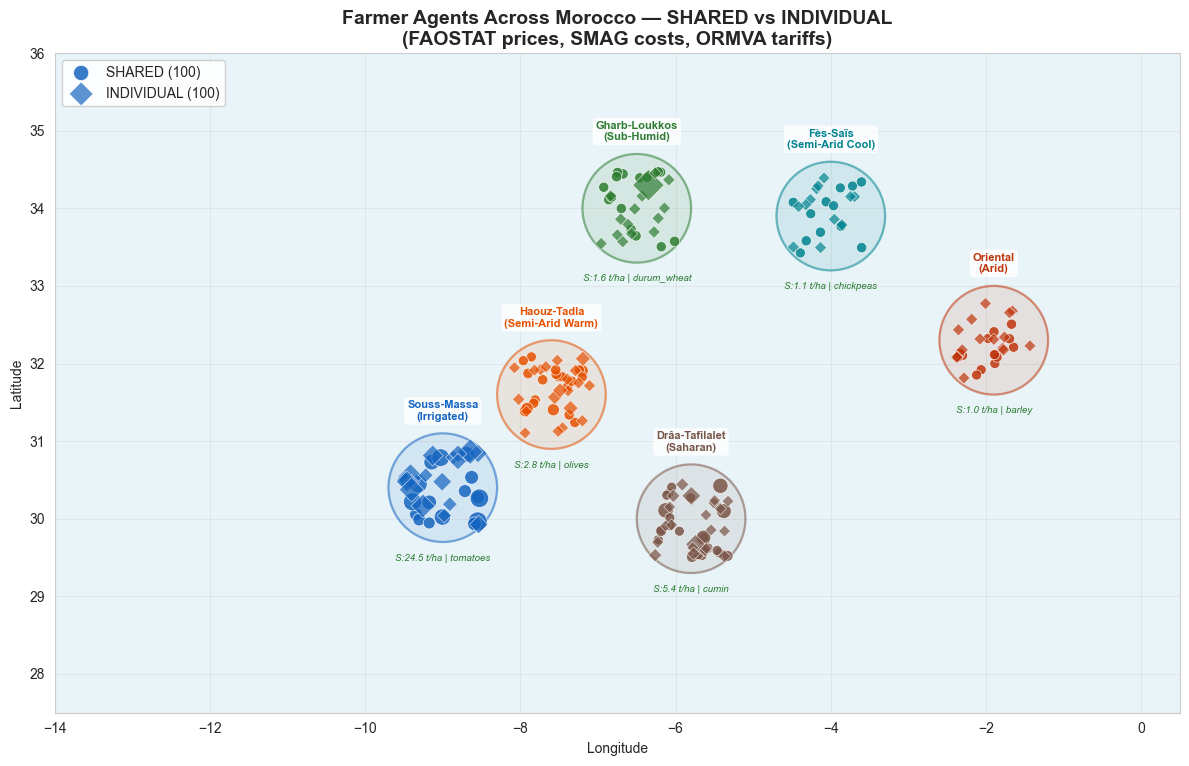

C:\Users\pc\AppData\Local\Temp\ipykernel_15448\523554492.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="strategy", y="yield", data=df, ax=axes[0], palette="Set2")
C:\Users\pc\AppData\Local\Temp\ipykernel_15448\523554492.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="strategy", y="profit", data=df, ax=axes[1], palette="Set2")


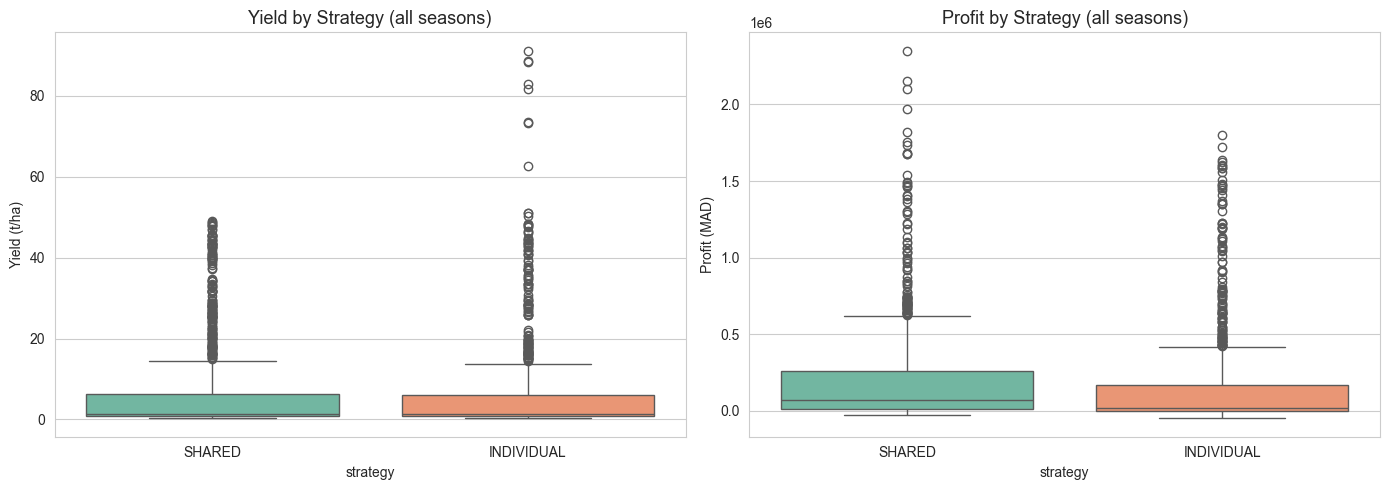

C:\Users\pc\AppData\Local\Temp\ipykernel_15448\523554492.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="strategy", y="yield", data=df, ax=axes[0],
C:\Users\pc\AppData\Local\Temp\ipykernel_15448\523554492.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="strategy", y="profit", data=df, ax=axes[1],


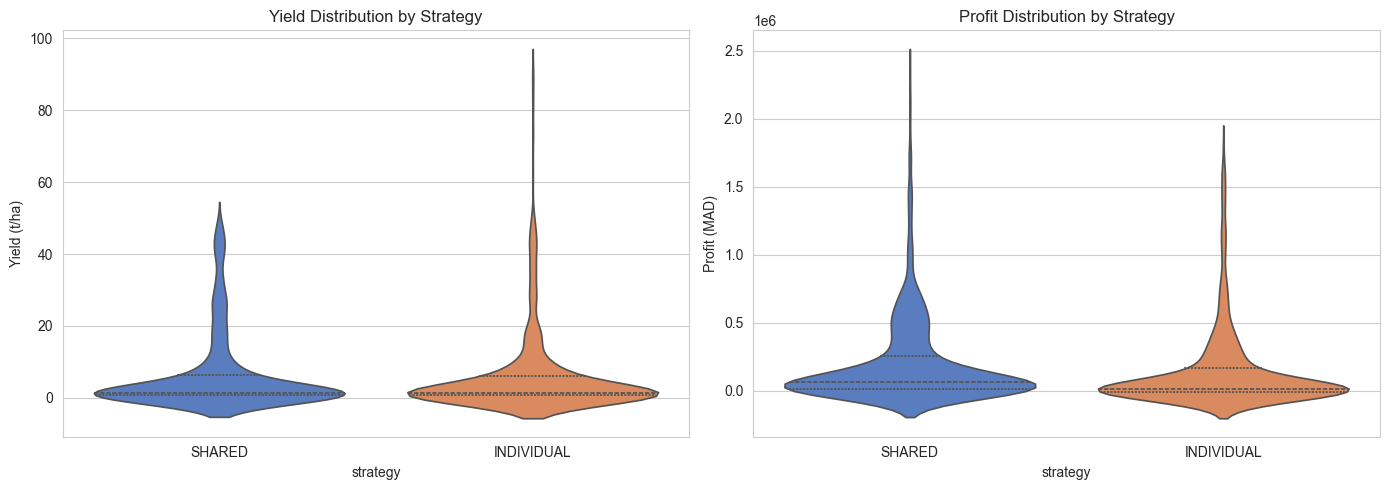

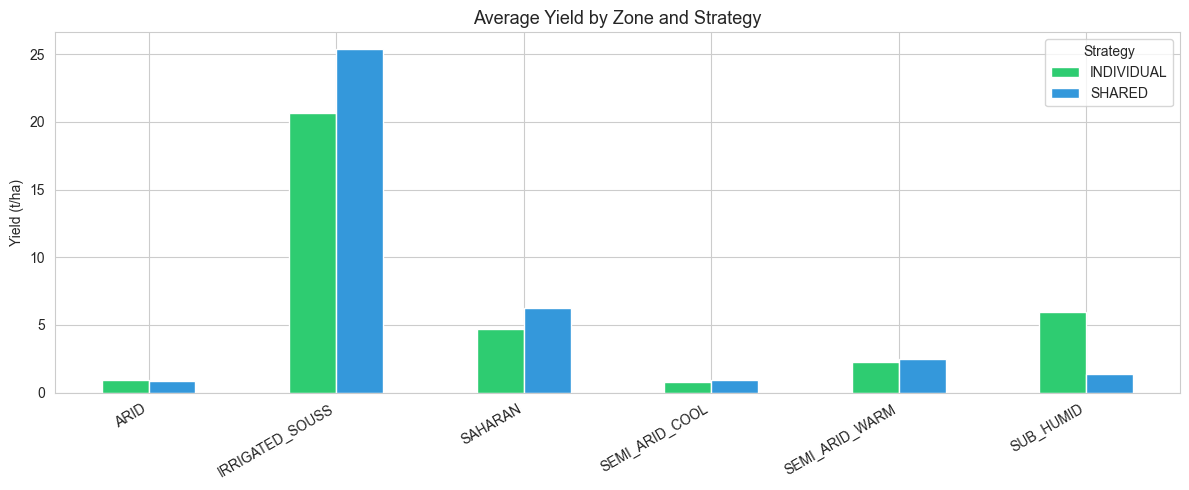

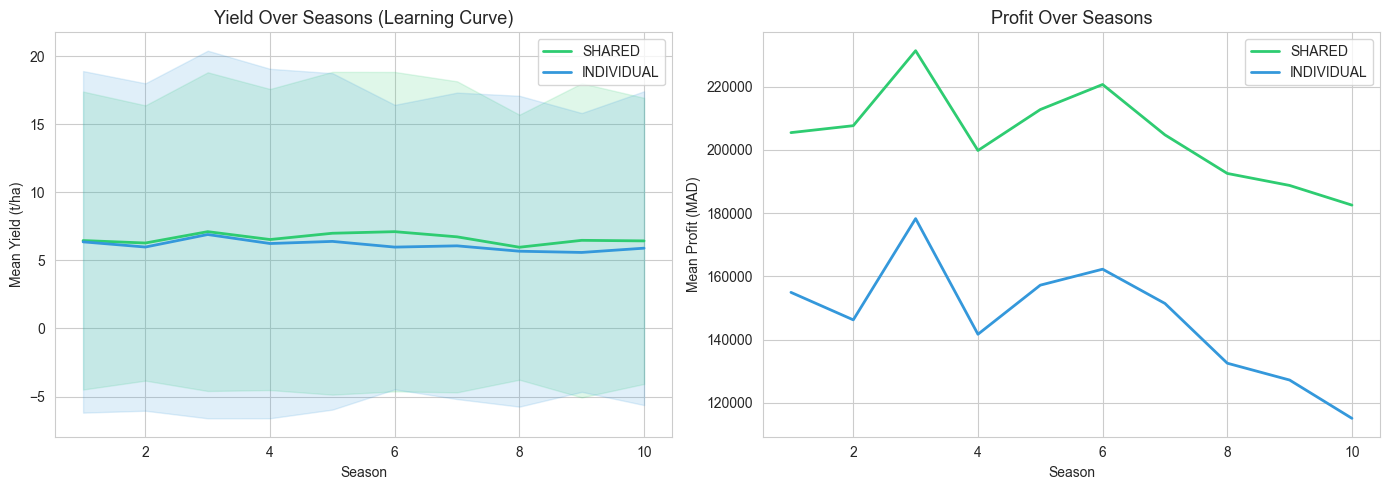

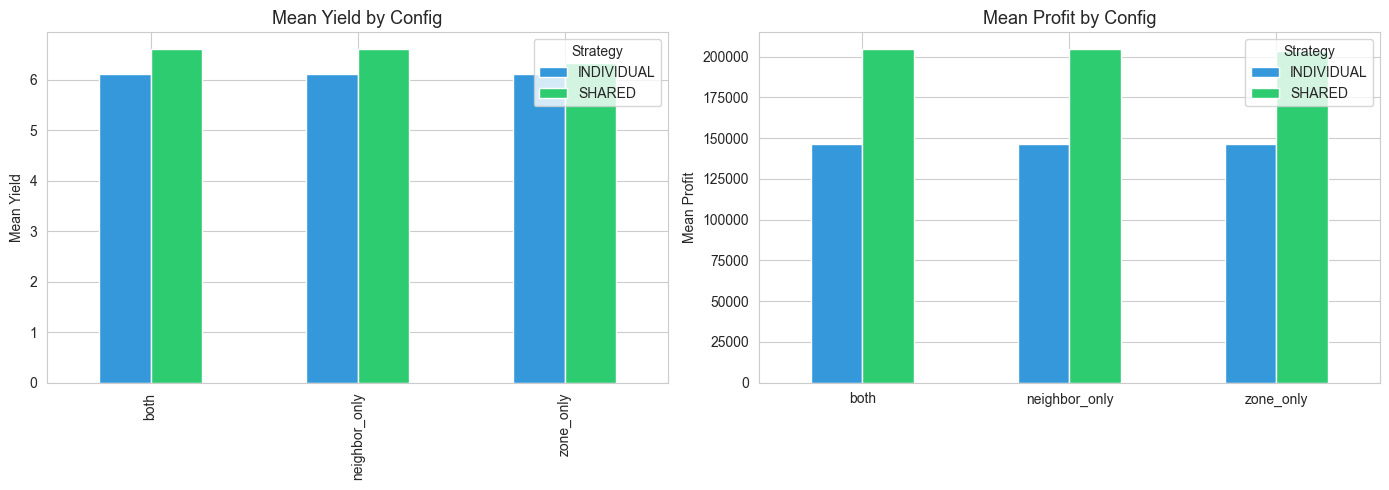


✓ Results saved to results/
  - agents_results.csv (2000 rows)
  - season_history.csv (10 rows)
  - strategy_comparison.csv (6 rows)
  - metrics.json
  - simulation_config.yaml

Data sources: FAOSTAT prices, SMAG labor, ORMVA water, OCP fertilizer, NASA POWER climate, Copernicus RZSM


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({"figure.dpi": 100, "figure.figsize": (12, 5)})

try:
    import seaborn as sns
    sns.set_style("whitegrid")
    HAS_SNS = True
except ImportError:
    HAS_SNS = False

results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

# =============================================================================
# 1. Morocco Map — Agent Scatter
# =============================================================================
ZONE_COORDS = {
    "IRRIGATED_SOUSS": (30.4, -9.0, "Souss-Massa\n(Irrigated)"),
    "SUB_HUMID": (34.0, -6.5, "Gharb-Loukkos\n(Sub-Humid)"),
    "SEMI_ARID_WARM": (31.6, -7.6, "Haouz-Tadla\n(Semi-Arid Warm)"),
    "SEMI_ARID_COOL": (33.9, -4.0, "Fès-Saïs\n(Semi-Arid Cool)"),
    "ARID": (32.3, -1.9, "Oriental\n(Arid)"),
    "SAHARAN": (30.0, -5.8, "Drâa-Tafilalet\n(Saharan)"),
}
ZONE_COLORS = {
    "IRRIGATED_SOUSS": "#1565c0", "SUB_HUMID": "#2e7d32",
    "SEMI_ARID_WARM": "#e65100", "SEMI_ARID_COOL": "#00838f",
    "ARID": "#bf360c", "SAHARAN": "#795548",
}

fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.set_facecolor("#e8f4f8")

for zid, (lat, lon, label) in ZONE_COORDS.items():
    circle = plt.Circle((lon, lat), 0.7, color=ZONE_COLORS[zid],
                         alpha=0.10, linewidth=2)
    ax.add_patch(circle)
    circle_border = plt.Circle((lon, lat), 0.7, fill=False,
                                color=ZONE_COLORS[zid], linewidth=1.5, alpha=0.5)
    ax.add_patch(circle_border)

# Use last-season data for map
last_season = df["timestep"].max()
map_df = df[df["timestep"] == last_season]

rng_map = np.random.RandomState(42)
for strat, marker, size_base, alpha in [
    ("SHARED", "o", 50, 0.85),
    ("INDIVIDUAL", "D", 35, 0.70),
]:
    sub = map_df[map_df["strategy"] == strat]
    lats, lons, colors, sizes = [], [], [], []
    for _, row in sub.iterrows():
        coords = ZONE_COORDS.get(row["zone"])
        if not coords:
            continue
        lat, lon, _ = coords
        lats.append(lat + rng_map.uniform(-0.5, 0.5))
        lons.append(lon + rng_map.uniform(-0.5, 0.5))
        colors.append(ZONE_COLORS.get(row["zone"], "#666"))
        sizes.append(size_base + row["yield"] * 3)
    ax.scatter(lons, lats, s=sizes, c=colors, marker=marker,
               alpha=alpha, edgecolors="white", linewidths=0.5,
               label=f"{strat} ({len(sub)})", zorder=3)

for zid, (lat, lon, label) in ZONE_COORDS.items():
    ax.annotate(label, (lon, lat + 0.85), fontsize=8, fontweight="bold",
                ha="center", va="bottom", color=ZONE_COLORS[zid],
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

for zid, (lat, lon, _) in ZONE_COORDS.items():
    z_shared = map_df[(map_df["zone"] == zid) & (map_df["strategy"] == "SHARED")]
    if len(z_shared) > 0:
        top_crop = z_shared["crop"].mode().iloc[0] if len(z_shared) > 0 else "?"
        ax.annotate(f"S:{z_shared['yield'].mean():.1f} t/ha | {top_crop}",
                    (lon, lat - 0.85), fontsize=7, ha="center", va="top",
                    color="#2e7d32", fontstyle="italic")

ax.set_xlim(-14, 0.5)
ax.set_ylim(27.5, 36)
ax.set_xlabel("Longitude", fontsize=10)
ax.set_ylabel("Latitude", fontsize=10)
ax.set_title("Farmer Agents Across Morocco — SHARED vs INDIVIDUAL\n(FAOSTAT prices, SMAG costs, ORMVA tariffs)", fontsize=14, fontweight="bold")
ax.legend(loc="upper left", fontsize=10, framealpha=0.9)
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(results_dir / "00_morocco_map.png", bbox_inches="tight", dpi=150)
plt.show()

# =============================================================================
# 2. Box plots — yield + profit
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if HAS_SNS:
    sns.boxplot(x="strategy", y="yield", data=df, ax=axes[0], palette="Set2")
else:
    for i, strat in enumerate(["SHARED", "INDIVIDUAL"]):
        sub = df[df["strategy"] == strat]["yield"]
        axes[0].boxplot(sub, positions=[i], widths=0.5)
axes[0].set_title("Yield by Strategy (all seasons)", fontsize=13)
axes[0].set_ylabel("Yield (t/ha)")

if HAS_SNS:
    sns.boxplot(x="strategy", y="profit", data=df, ax=axes[1], palette="Set2")
else:
    for i, strat in enumerate(["SHARED", "INDIVIDUAL"]):
        sub = df[df["strategy"] == strat]["profit"]
        axes[1].boxplot(sub, positions=[i], widths=0.5)
axes[1].set_title("Profit by Strategy (all seasons)", fontsize=13)
axes[1].set_ylabel("Profit (MAD)")

plt.tight_layout()
plt.savefig(results_dir / "01_strategy_comparison.png", bbox_inches="tight")
plt.show()

# =============================================================================
# 3. Violin plots
# =============================================================================
if HAS_SNS:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.violinplot(x="strategy", y="yield", data=df, ax=axes[0],
                   inner="quartile", palette="muted")
    axes[0].set_title("Yield Distribution by Strategy")
    axes[0].set_ylabel("Yield (t/ha)")

    sns.violinplot(x="strategy", y="profit", data=df, ax=axes[1],
                   inner="quartile", palette="muted")
    axes[1].set_title("Profit Distribution by Strategy")
    axes[1].set_ylabel("Profit (MAD)")
    plt.tight_layout()
    plt.savefig(results_dir / "02_distribution_analysis.png", bbox_inches="tight")
    plt.show()

# =============================================================================
# 4. Per-zone performance
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 5))
zone_perf = df.groupby(["zone", "strategy"])["yield"].mean().unstack()
zone_perf.plot(kind="bar", ax=ax, color=["#2ecc71", "#3498db"])
ax.set_title("Average Yield by Zone and Strategy", fontsize=13)
ax.set_ylabel("Yield (t/ha)")
ax.set_xlabel("")
ax.legend(title="Strategy")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(results_dir / "03_zone_performance.png", bbox_inches="tight")
plt.show()

# =============================================================================
# 5. Learning curves (season-by-season)
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(hist_df["season"], hist_df["shared_mean_yield"],
             label="SHARED", color="#2ecc71", linewidth=2)
axes[0].plot(hist_df["season"], hist_df["indiv_mean_yield"],
             label="INDIVIDUAL", color="#3498db", linewidth=2)
axes[0].fill_between(hist_df["season"],
                     hist_df["shared_mean_yield"] - hist_df["shared_std_yield"],
                     hist_df["shared_mean_yield"] + hist_df["shared_std_yield"],
                     alpha=0.15, color="#2ecc71")
axes[0].fill_between(hist_df["season"],
                     hist_df["indiv_mean_yield"] - hist_df["indiv_std_yield"],
                     hist_df["indiv_mean_yield"] + hist_df["indiv_std_yield"],
                     alpha=0.15, color="#3498db")
axes[0].set_title("Yield Over Seasons (Learning Curve)", fontsize=13)
axes[0].set_xlabel("Season")
axes[0].set_ylabel("Mean Yield (t/ha)")
axes[0].legend()

axes[1].plot(hist_df["season"], hist_df["shared_mean_profit"],
             label="SHARED", color="#2ecc71", linewidth=2)
axes[1].plot(hist_df["season"], hist_df["indiv_mean_profit"],
             label="INDIVIDUAL", color="#3498db", linewidth=2)
axes[1].set_title("Profit Over Seasons", fontsize=13)
axes[1].set_xlabel("Season")
axes[1].set_ylabel("Mean Profit (MAD)")
axes[1].legend()

plt.tight_layout()
plt.savefig(results_dir / "04_learning_curves.png", bbox_inches="tight")
plt.show()

# =============================================================================
# 6. Strategy comparison across configs
# =============================================================================
if comp_df is not None and len(comp_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for i, metric in enumerate(["mean_yield", "mean_profit"]):
        pivot = comp_df.pivot(index="config", columns="strategy", values=metric)
        pivot.plot(kind="bar", ax=axes[i], color=["#3498db", "#2ecc71"])
        axes[i].set_title(f"{metric.replace('_', ' ').title()} by Config", fontsize=13)
        axes[i].set_ylabel(metric.replace("_", " ").title())
        axes[i].set_xlabel("")
        axes[i].legend(title="Strategy")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(results_dir / "05_config_comparison.png", bbox_inches="tight")
    plt.show()

# =============================================================================
# 7. Export results
# =============================================================================
df.to_csv(results_dir / "agents_results.csv", index=False)
hist_df.to_csv(results_dir / "season_history.csv", index=False)
comp_df.to_csv(results_dir / "strategy_comparison.csv", index=False)

_shared_df = df[df["strategy"]=="SHARED"]
_indiv_df = df[df["strategy"]=="INDIVIDUAL"]
_avg_y_s = float(_shared_df["yield"].mean())
_avg_y_i = float(_indiv_df["yield"].mean())
_avg_p_s = float(_shared_df["profit"].mean())
_avg_p_i = float(_indiv_df["profit"].mean())

metrics = {
    "total_agents": int(df["agent_id"].nunique()),
    "shared_agents": int(_shared_df["agent_id"].nunique()),
    "individual_agents": int(_indiv_df["agent_id"].nunique()),
    "n_seasons": int(cfg.n_seasons),
    "shared_strategy": cfg.shared_strategy,
    "use_neighbor_graph": cfg.use_neighbor_graph,
    "avg_yield_shared": round(_avg_y_s, 4),
    "avg_yield_individual": round(_avg_y_i, 4),
    "yield_advantage_shared": round(_avg_y_s - _avg_y_i, 4),
    "avg_profit_shared": round(_avg_p_s, 2),
    "avg_profit_individual": round(_avg_p_i, 2),
    "profit_advantage_shared": round(_avg_p_s - _avg_p_i, 2),
    "profit_advantage_pct": round(
        (_avg_p_s - _avg_p_i) / abs(_avg_p_i) * 100 if _avg_p_i else 0, 2
    ),
    "data_sources": {
        "crop_prices": "FAOSTAT Morocco (crops.json → faostat_price_mad_per_ton)",
        "labor_costs": f"SMAG {crops_data['cost_model']['smag_mad_per_day']} MAD/day",
        "water_tariffs": "ORMVA zone-specific (zones.json → water_price)",
        "fertilizer": "OCP NPK by crop category (crops.json → cost_model)",
        "climate": "NASA POWER + EcoCrop (climate_profiles.json)",
        "soil_moisture": "Copernicus C3S RZSM (soil_moisture_profiles.json)",
    },
}

import json as _json
with open(results_dir / "metrics.json", "w") as f:
    _json.dump(metrics, f, indent=2)

import yaml as _yaml
with open(results_dir / "simulation_config.yaml", "w") as f:
    _yaml.dump(cfg.__dict__, f, default_flow_style=False)

print(f"\n✓ Results saved to {results_dir}/")
print(f"  - agents_results.csv ({len(df)} rows)")
print(f"  - season_history.csv ({len(hist_df)} rows)")
print(f"  - strategy_comparison.csv ({len(comp_df)} rows)")
print(f"  - metrics.json")
print(f"  - simulation_config.yaml")
print(f"\nData sources: FAOSTAT prices, SMAG labor, ORMVA water, OCP fertilizer, NASA POWER climate, Copernicus RZSM")